Today we're going to demonstrate how we can use python and data analysis to make informed decisions when drafting pitchers during a season long fantasy baseball draft. To do this we're going to focus on variance. We're going to explore the variance among 100 pitchers ERA projections for the upcoming 2023 season and which players have the highest/lowest variance among their projections. As a general rule of thumb we want to target players with a low projected ERA and low variance among their projections. We can also look at the high variance players so we know which players to avoid in drafts because they could be deemed as a risky play. 

In [40]:
# Import Modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# Create a list for stat columns to grab from projection files
cols = ['Name','Team','ERA']

# Read in projection files, rename ERA columns, and set index as (Name,Team)
atc_df=pd.read_csv('atcSP100.csv',usecols=cols)
atc_df.rename({'ERA':'atc_ERA'},
             axis=1,
             inplace=True)
atc_df.set_index(['Name','Team'],
                inplace=True)

steamer_df = pd.read_csv('steamerSP100.csv',usecols=cols)
steamer_df.rename({'ERA':'steamer_ERA'},
                 axis=1,
                 inplace=True)
steamer_df.set_index(['Name','Team'],
                    inplace=True)

thebat_df = pd.read_csv('thebatSP100.csv',usecols=cols)
thebat_df.rename({'ERA':'thebat_ERA'},
                axis=1,
                inplace=True)
thebat_df.set_index(['Name','Team'],
                   inplace=True)

zips_df=pd.read_csv('zipsSP100.csv',usecols=cols)
zips_df.rename({'ERA':'zips_ERA'},
              axis=1,
              inplace=True)
zips_df.set_index(['Name','Team'],
                 inplace=True)

# Join projection files into one data frame
df = atc_df.join(steamer_df).join(thebat_df).join(zips_df)

# Reset Index
df.reset_index(inplace=True)

# Compute Variance for Projected ERA
df['ERA_projection_variance']=df[['atc_ERA','steamer_ERA','thebat_ERA','zips_ERA']].var(axis=1)
df['avg_projected_ERA'] = df[['atc_ERA','steamer_ERA','thebat_ERA','zips_ERA']].mean(axis=1)

# round columns to 2 decimal places
df=df.round(2)
df.sort_values(by='ERA_projection_variance',
               ascending=False,
               inplace=True)

# Filter projections down to pitchers with average projected ERA in the lowest 25th percentile of the dataframe
# This is so we can do assess the confidence in the projections of the top projected pitchers by ERA
pct25 = round(df.avg_projected_ERA.quantile(0.25),2)
df=df[df.avg_projected_ERA<=pct25]


For our variance analysis, we filtered our 100 available players down to the lowest 25th percentile of players ERA projections. This is so we can focus on the best projected pitchers with respect to projected ERA. This results in 38 pitchers whos average projected era is less than or equal to the the 25th percentile of the 100 available pithers. 

<Figure size 640x480 with 0 Axes>

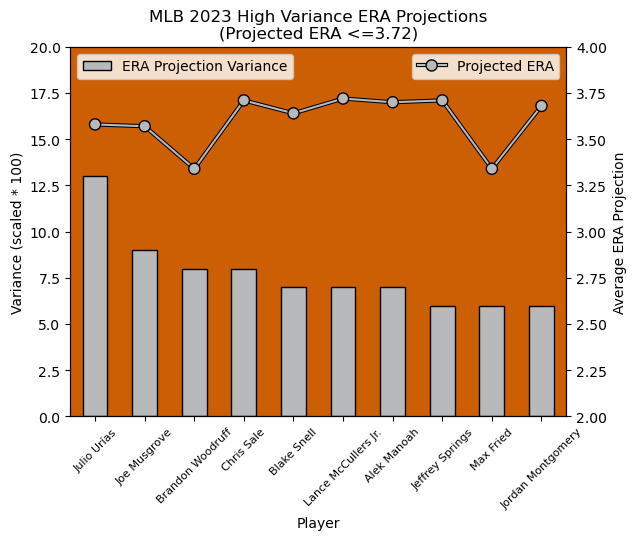

In [41]:
#Plot Top 10 Players With Highest ERA Projection Variance to get a view of the "riskiest" 
# draft prospects
temp = df.copy()

# Scale Variance column by 100
temp.ERA_projection_variance *= 100

# Rename ERA_projection_variance column to something more descriptive for our visual
# Also rename Name to Player
temp.rename({
      'ERA_projection_variance': 'ERA Projection Variance',
      'Name': 'Player'
    }, axis=1, inplace=True)

# Make a bar plot for variance
fig = plt.figure()
ax = temp.head(10).plot.bar('Player',
                            'ERA Projection Variance',
                           color='#B7B9BB',
                           edgecolor='black')
plt.xticks(rotation=45,
          fontsize=8)
plt.title(f'MLB 2023 High Variance ERA Projections\n(Projected ERA <={pct25})')
ax.set_ylabel('Variance (scaled * 100)')
ax.set_ylim(0, 20)
ax.set_facecolor('#CC5E04')
# Overlay Projected ERA
ax2 = ax.twinx()
ax2.plot(temp.head(10).Player, 
         temp.head(10).avg_projected_ERA, 
         color="#B7B9BB", 
         marker="o",
        path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax2.set_ylabel("Average ERA Projection")
ax2.set_ylim(2.0, 4.0)
ax2.legend(['Projected ERA'], loc='upper right')
ax.legend(loc='upper left');

In the plot above we're looking at players with the highest variance in their projected ERA for the 2023 season. This plot tells us that of the players in the lowest 25th percentile for 2023 projeted ERA, Julio Urias has the highest variance in projected ERA for the upcoming season. This is valuable information for season long drafts since Julio Urias ranks in the top 25th percentile in terms of average projected ERA. 
Lets take a look at Julio Urias' career stats to get a look at why there is high variance in his projections across multiple sites.

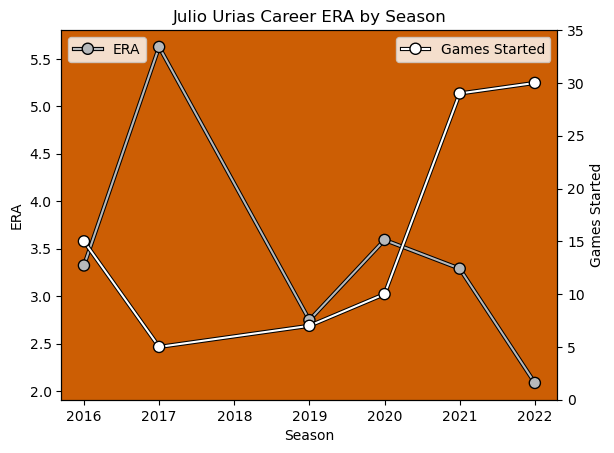

In [64]:
# Read in Julio Urias game data

import numpy as np
julio = pd.read_csv('julio_urias.csv')
julio.sort_values(by='game_date',inplace=True)

temp = julio.groupby('season', as_index=False).agg(
    {'earnedRuns':np.sum,
     'gamesStarted':np.sum,
     'inningsPitched':np.sum,
    }
)
temp['ERA']=(temp.earnedRuns*9)/temp.inningsPitched

ax = temp.plot('season', 
               'ERA', 
               marker='o',
               color="#B7B9BB", 
               path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]
              )
              
ax.set_ylabel('ERA')
ax.set_xlabel('Season')
ax.set_title('Julio Urias Career ERA by Season')
ax.set_facecolor('#CC5E04')
ax2 = ax.twinx()
ax2.plot(temp.season, 
         temp.gamesStarted,
         color="white", 
         marker="o",
        path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax2.set_ylabel("Games Started",)
ax2.set_ylim(0,35)
ax2.legend(['Games Started'], loc='upper right')
ax.legend(loc='upper left');

During the last 2 seasons Julio Urias has had his most starts in a season as an MLB pitcher. Another promising trend is that since 2020, Urias has seen his seasong long ERA come down below 3.0. I think the big takeaway from this chart is that the sample size for full seasons pitched by Urias is pretty small with really only 2 full seasons under his belt. Prior to 2021, Urias at most only had half the number of starts he's had in the last two seasons, and in those early seasons in his career his ERA was rather erratic. This provides some insight into the high variance among his projections. Some experts may be leaning toward the downward trend his season long ERA has followed since 2020, while others may have more conservative projections that stem from recognizing he's only been a true starter for the last 2 seasons. Another way we can assess Urias' high variance projections is by looking at his 8 game and 32 game running ERA throughout his career. This gives insight into his volatility as a starter from game to game. We use 8 games and 32 games since these are roughly a quarter and full season for a starting pitchers respectively. The 8 game running average lets use see if Urias has a tendency for hot/cold streaks relative to his 32 game (or season long) average)

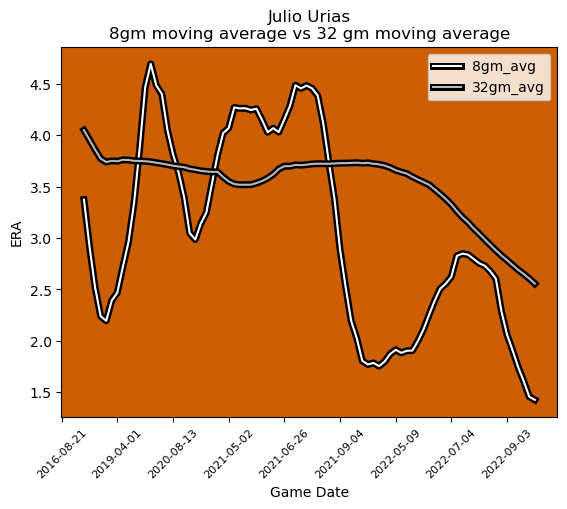

In [73]:
# Make sure dataframe is sorted chronologically
julio.sort_values(by='game_date',inplace=True)
julio['32gm_inningsPitched'] = julio.inningsPitched.rolling(window=32, min_periods=8).sum()
julio['32gm_earnedRuns'] = julio.earnedRuns.rolling(window=32, min_periods=8).sum()
julio['32gm_ERA']=(julio['32gm_earnedRuns']*9)/julio['32gm_inningsPitched']
julio['8gm_inningsPitched'] = julio.inningsPitched.rolling(window=8, min_periods=8).sum()
julio['8gm_earnedRuns'] = julio.earnedRuns.rolling(window=8, min_periods=8).sum()
julio['8gm_ERA']=(julio['8gm_earnedRuns']*9)/julio['8gm_inningsPitched']

julio['32gm_avg'] = julio['32gm_ERA'].rolling(window=32, min_periods=8).mean()
julio['8gm_avg'] = julio['8gm_ERA'].rolling(window=8, min_periods=8).mean()

fig,ax=plt.subplots()
ax=julio.plot('game_date', 
              ['8gm_avg','32gm_avg'],
              color=['white',"#B7B9BB"],
              path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
             ax=ax)
plt.xticks(rotation=45,
          fontsize=8)
ax.set_facecolor('#CC5E04')
ax.set_title('Julio Urias\n8gm moving average vs 32 gm moving average')
ax.set_ylabel('ERA')
ax.set_xlabel('Game Date');

In the plot above we can see Urias' 32 game moving ERA steadily decline during and after the 2021 season. However, we see a period during the 22 season where his 8 game moving average spiked. This shows us that he had a pretty tough stretch relative to what he's capable of for a period of time during the 2022 season. The 32gm  average has a very promising trend which again may be a reason why some experts have him for a lower projected ERA than others. On the other hand, the handful of poor performances he had last year may be resulting in some experts putting out more conservative projections for his ERA this year. Now lets look at some pitchers with low variance projections. 

<Figure size 640x480 with 0 Axes>

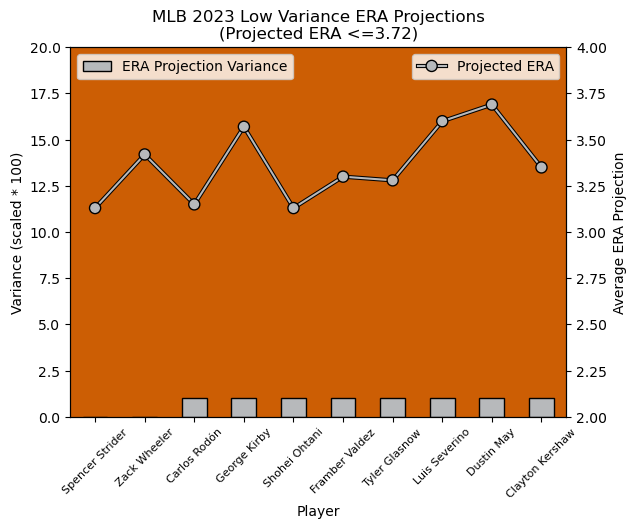

In [60]:
#Plot Top 10 Players With Lowest ERA Projection Variance to get a view of the "high confidence" 
# draft prospects

temp = df.copy()
# Sort variance from lowest to highest
temp.sort_values(by='ERA_projection_variance',
                inplace=True)
# Scale Variance column by 100
temp.ERA_projection_variance *= 100

# Rename ERA_projection_variance column to something more descriptive for our visual
# Also rename Name to Player
temp.rename({
      'ERA_projection_variance': 'ERA Projection Variance',
      'Name': 'Player'
    }, axis=1, inplace=True)

# Make a bar plot for variance
fig = plt.figure()
ax = temp.head(10).plot.bar('Player',
                            'ERA Projection Variance',
                           color='#B7B9BB',
                           edgecolor='black')
plt.xticks(rotation=45,
          fontsize=8)
plt.title(f'MLB 2023 Low Variance ERA Projections\n(Projected ERA <={pct25})')
ax.set_ylabel('Variance (scaled * 100)')
ax.set_ylim(0, 20)
ax.set_facecolor('#CC5E04')
# Overlay Projected ERA
ax2 = ax.twinx()
ax2.plot(temp.head(10).Player, 
         temp.head(10).avg_projected_ERA, 
         color="#B7B9BB", 
         marker="o",
        path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax2.set_ylabel("Average ERA Projection")
ax2.set_ylim(2.0, 4.0)
ax2.legend(['Projected ERA'], loc='upper right')
ax.legend(loc='upper left');

The plot above shows us the 10 pitchers with the lowest variance in their ERA projections for the 2023 season. These 10 pitchers are pulled from the top 38 players (25th percentile) with respect to average projected ERA from a list of 100 starting pitchers. We can see that Spencer Strider has the lowest variance among his projections for the upcoming season. Furthermore, his average projected ERA is somewhere between 3 and 3.25. With near 0 variance (scale *100) in his projections, we can draft strider with confidence that his season long projected ERA will come to fruition since all experts seem to be landing on the same projection. A few other notable pitchers with low variance/low projected ERA are Carlos Rodon and Shohei Ohtani. Similar to what we did with Julio Urias, lets look at Carlos Rodon's career ERA stats and see why several experts are landing on a very similar projected ERA for Rodon in 2023. 

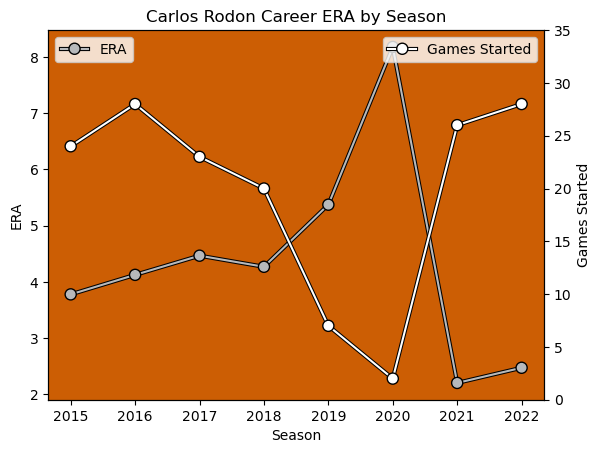

In [74]:
# Read in Carolo Rodon game data

import numpy as np
julio = pd.read_csv('carlos_rodon.csv')
julio.sort_values(by='game_date',inplace=True)

temp = julio.groupby('season', as_index=False).agg(
    {'earnedRuns':np.sum,
     'gamesStarted':np.sum,
     'inningsPitched':np.sum,
    }
)
temp['ERA']=(temp.earnedRuns*9)/temp.inningsPitched

ax = temp.plot('season', 
               'ERA', 
               marker='o',
               color="#B7B9BB", 
               path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()]
              )
              
ax.set_ylabel('ERA')
ax.set_xlabel('Season')
ax.set_title('Carlos Rodon Career ERA by Season')
ax.set_facecolor('#CC5E04')
ax2 = ax.twinx()
ax2.plot(temp.season, 
         temp.gamesStarted,
         color="white", 
         marker="o",
        path_effects=[pe.Stroke(linewidth=3, foreground='black'), pe.Normal()])
ax2.set_ylabel("Games Started",)
ax2.set_ylim(0,35)
ax2.legend(['Games Started'], loc='upper right')
ax.legend(loc='upper left');

In the plot above we see Carlos Rodon's ERA by season dating back to 2015. This plot indicates a high ERA for Rodon during the 2019/2020 seasons, but he only started a few games during those years. Early in his career, when Rodon was starting 15 games or more, his ERA ranged from roughly 4 to 4.5. In the last 2 years, his ERA has improved dramatically with values under 2.5 in both 2021 and 2022. This is actually a type of profile where you might expect high variance among Rodon's projections. However, in our first plot we see his average projected ERA (~3.15) is well above the ERA he has posted in the last 2 seasons. If you were an expert, how could you project a pitchers ERA for the upcoming season when his last 2 seasons vary so dramatically than the previous 6 seasons in his career? Well the first thing I would do is remove those outlier years where Rodon only had a few starts (2019 and 2020). Then you could just take an average of his remaining seasons. However, we don't want to write off the fact that his last 2 seasons have been the best of his career. So lets see what happens if we take a weighted average, putting more weight on his most recent seasons.

In [93]:
# Remove 2019/2020 seasons
temp=temp[~temp.season.isin([2019,2020])]

# Get exponentially weighted moving average, and take the last sample which represents the moving average
# at the end of the 2022 season
my_projection = temp.ERA.ewm(span=6,min_periods=1).mean().tail(1).round(2).values[0]
df.loc[df.Name=='Carlos Rodón','my_projection']=my_projection
print(f'My projection for Carlos Rodon this season is an ERA of {my_projection}')

My projection for Carlos Rodon this season is an ERA of 3.17


In [96]:
# How does this fit in with the other projections?
df[df.Name=='Carlos Rodón'][['Name','atc_ERA','steamer_ERA','thebat_ERA','zips_ERA','avg_projected_ERA','my_projection']]

,Name,atc_ERA,steamer_ERA,thebat_ERA,zips_ERA,avg_projected_ERA,my_projection
93,Carlos Rodón,3.18,3.16,3.23,3.03,3.15,3.17


We see above that our projection falls directly between the projections from atc and steamer. If I had to guess, I'd say the low variance for Rodon's projections comes from the fact that there's really only one logical way to make a prediction for his upcoming 2023 season. I'd bet that the experts behind his low variance projections all had a methodology somewhat similar to the one we just demonstrated. This is largely because his last 2 seasons differ so greatly from the seasons he started a sufficient number of games prior to the 2019/2020 seasons. 